# Oceanum Hindcast Validation Auckland

Compare historical wave observations in the Hauraki Gulf against the Oceanum wave hindcast

This notebook requires the following python libraries:

- oceanum
- numpy
- matplotlib
- cartopy
- pandas
- geopandas
- xarray
- cmocean

In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmocean
import cartopy.crs as ccrs

from oceanum.datamesh import Connector

import warnings
warnings.filterwarnings("ignore")

## Datamesh connector

Put your datamesh token in the Jupyterlab settings, or as the `token` argument in the constructor below

In [3]:
datamesh = Connector()

## Wave observations

Load wave buoy timeseries from the Old Anchorite and Mokohinau sites in the Hauraki Gulf

#### Old Anchorite Rock buoy

Use the `variables` parameter to select the required variables and the `timefilter` parameter to query a specific time range.

In [4]:
query_ancho = {
    "datasource": "wave_buoy_old_anchorite_rock",
    "variables": ["lat", "lon", "hs"],
    "timefilter": {"times": ["2015-01-01T00:00:00", "2016-01-01T00:00:00"]},
}
ancho = datamesh.query(query_ancho)
ancho

<xarray.Dataset> Size: 350kB
Dimensions:  (time: 10937)
Coordinates:
  * time     (time) datetime64[ns] 87kB 2015-02-04T01:31:00 ... 2015-10-07T09...
Data variables:
    lat      (time) float64 87kB -36.42 -36.42 -36.42 ... -36.42 -36.42 -36.42
    lon      (time) float64 87kB 175.1 175.1 175.1 175.1 ... 175.1 175.1 175.1
    hs       (time) float64 87kB 0.459 0.477 0.477 0.513 ... 0.569 0.55 0.531
Attributes:
    description:             Wave buoy data from Old Anchorite Rock
    institution:             Auckland Council
    source:                  ARCwave
    title:                   Old Anchorite Rock buoy data
    _coordinates:            {"t":"time"}
    _request_size:           349984
    _domain_size:            10937
    _flattened_domain_size:  10937

#### Mokohinau buoy

Here we ignore the `timefilter` parameter to query the entire data period available

In [5]:
query_moko = {
    "datasource": "wave_buoy_mokohinau",
    "variables": ["lat", "lon", "hs"],
}
moko = datamesh.query(query_moko)
moko

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 34929)
Coordinates:
  * time     (time) datetime64[ns] 279kB 1998-04-30T12:14:00 ... 2004-03-04T2...
Data variables:
    lat      (time) float64 279kB nan nan -35.9 -35.9 ... -35.9 -35.9 -35.9 nan
    lon      (time) float64 279kB nan nan 175.1 175.1 ... 175.1 175.1 175.1 nan
    hs       (time) float64 279kB nan nan 0.4503 0.4921 ... 0.8229 0.7497 nan
Attributes:
    description:             Wave buoy data from Mokohinau with spikes removed
    institution:             Auckland Council
    source:                  ARCwave
    title:                   Mokohinau buoy data
    _coordinates:            {"t":"time"}
    _request_size:           1117728
    _domain_size:            34929
    _flattened_domain_size:  34929

## Bathy and GIS

Load bathy data from GEBCO and land polygon from OSM to make a map of the buoy locations

#### GEBCO
Use the `geofilter` parameter to query the data inside a bounding box

In [6]:
query_gebco = {
    "datasource": "gebco_2024",
    "geofilter": {
        "type": "bbox",
        "geom": [174.4, -37.25, 176.0, -35.75]
    }
}
gebco = datamesh.query(query_gebco)
gebco

<xarray.Dataset> Size: 1MB
Dimensions:    (lat: 360, lon: 384)
Coordinates:
  * lat        (lat) float64 3kB -37.25 -37.24 -37.24 ... -35.76 -35.76 -35.75
  * lon        (lon) float64 3kB 174.4 174.4 174.4 174.4 ... 176.0 176.0 176.0
Data variables:
    elevation  (lat, lon) float64 1MB -64.0 -63.0 -62.0 ... -350.0 -357.0 -363.0
Attributes: (12/39)
    Conventions:                     CF-1.6, ACDD-1.3
    comment:                         The data in the GEBCO_2024 Grid should n...
    creator_email:                   gdacc@seabed2030.org
    creator_name:                    GEBCO through the Nippon Foundation-GEBC...
    creator_type:                    International organisation
    creator_url:                     https://www.gebco.net
    ...                              ...
    source:                          The GEBCO_2024 Grid is the 2024 release ...
    summary:                         The GEBCO_2024 Grid is a continuous, glo...
    title:                           The GEBCO_2024 Grid - a continuous terra...
    _coordinates:                    {"x":"lon","y":"lat"}
    _request_size:                   1111872
    _domain_size:                    138240

#### Land polygon

Reuse the gebco query parameters replacing only the datasource id 

In [7]:
query_land = query_gebco.copy()
query_land["datasource"] = "osm-land-polygons"

land = datamesh.query(query_land).dissolve()
land.head()

,geom,x,y
0,"MULTIPOLYGON (((174.66408 -37.11085, 174.66406...",175,-37


## New Zealand wave hindcast

Query co-temporal timeseries at the nearest sites from the buoys

### Search for available datasets

The `get_catalog` method allows searching datasources by tags

In [8]:
cat = datamesh.get_catalog(search="new zealand era5 wave hindcast parameters")
list(cat)

[
         Oceanum New Zealand ERA5 multiscale wave parameters hindcast [oceanum_wave_nz1km_multiscale_era5_param]
             Extent: (165.0, -48.0, 180.0, -34.0)
             Timerange: 1979-02-01 00:00:00+00:00 to 2023-01-01 00:00:00+00:00
         ,
 
         Oceanum Taranaki ERA5 wave hindcast parameters [oceanum_wave_trki_era5_v1_grid]
             Extent: (173.0, -40.0, 175.1999969482422, -37.79999923706055)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-07-01 00:00:00+00:00
         ,
 
         Oceanum New Zealand ERA5 wave hindcast parameters [oceanum_wave_nz_era5_v1_grid]
             Extent: (165.0, -48.0, 180.0, -34.0)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-07-01 00:00:00+00:00
         ]

### Query point timeseries

Load co-temporal timeseries from the Oceanum wave hindcast datasources. Below we define a function to query based on time and loction

In [9]:
def query_hindcast(datasource, obs):
    """Query hindcast timeseries colocated to the obs dataset.

    Parameters
    ----------
    datasource: str
        The ID of the Datamesh datasource to query from.
    obs: xr.Dataset
        The obs dataset specifying the location and times to query.

    Return
    ------
    hds: xr.Dataset
        The queried hindcast timeseries.

    """
    lon = float(obs.lon.mean())
    lat = float(obs.lat.mean())
    t0, t1 = obs.time.to_index().to_pydatetime()[[0, -1]]

    query = {
        "datasource": datasource,
        "variables": ["hs"],
        "timefilter": {
            "type": "range",
            "times": [t0, t1],
        },
        "geofilter": {
            "type": "feature",
            "geom": {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": [[lon, lat]],
                },
            },
        },
    }
    return datamesh.query(query).squeeze()

### Oceanum New Zealand 5km dataset

This dataset covers the entire country and extends from February 1979 up until the previous month at 3-hourly resolution

#### Old Anchorite Rock

In [10]:
hds_nz5km_ancho = query_hindcast(datasource="oceanum_wave_nz_era5_v1_grid", obs=ancho)
hds_nz5km_ancho

<xarray.Dataset> Size: 31kB
Dimensions:      (time: 1963)
Coordinates:
  * time         (time) datetime64[ns] 16kB 2015-02-04T03:00:00 ... 2015-10-0...
    spatial_ref  int64 8B 0
    longitude    float64 8B 175.1
    latitude     float64 8B -36.42
Data variables:
    hs           (time) float64 16kB 0.3988 0.3933 0.3852 ... 0.3192 0.4098
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 New Zealand
    run:                     nz
    xinterp_method:          linear
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           31432
    _domain_size:            1963
    _flattened_domain_size:  1963

#### Mokohinau

In [11]:
hds_nz5km_moko = query_hindcast(datasource="oceanum_wave_nz_era5_v1_grid", obs=moko)
hds_nz5km_moko

<xarray.Dataset> Size: 273kB
Dimensions:      (time: 17082)
Coordinates:
  * time         (time) datetime64[ns] 137kB 1998-04-30T15:00:00 ... 2004-03-...
    spatial_ref  int64 8B 0
    longitude    float64 8B 175.1
    latitude     float64 8B -35.9
Data variables:
    hs           (time) float64 137kB 0.5713 0.5778 0.5908 ... 1.054 1.157 1.232
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 New Zealand
    run:                     nz
    xinterp_method:          linear
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           273336
    _domain_size:            17082
    _flattened_domain_size:  17082

### Oceanum New Zealand 1km dataset

This dataset covers the entire country and extends from February 1979 up until 01 January 2023 at hourly resolution

<div class="alert alert-block alert-info">
⚠️ Once you have run this query once, rerunning it will be faster given the data will be cached
</div>

#### Old Anchorite Rock

In [12]:
hds_nz1km_ancho = query_hindcast(datasource="oceanum_wave_nz1km_multiscale_era5_param", obs=ancho)
hds_nz1km_ancho

<xarray.Dataset> Size: 94kB
Dimensions:      (time: 5888)
Coordinates:
  * time         (time) datetime64[ns] 47kB 2015-02-04T02:00:00 ... 2015-10-0...
    spatial_ref  int64 8B 0
    longitude    float64 8B 175.1
    latitude     float64 8B -36.42
Data variables:
    hs           (time) float64 47kB 0.4903 0.4934 0.488 ... 0.3673 0.3948
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 New Zealand grid
    run:                     nz11
    xinterp_method:          linear
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           94232
    _domain_size:            5888
    _flattened_domain_size:  5888

#### Mokohinau

In [13]:
hds_nz1km_moko = query_hindcast(datasource="oceanum_wave_nz1km_multiscale_era5_param", obs=moko)
hds_nz1km_moko

<xarray.Dataset> Size: 820kB
Dimensions:      (time: 51248)
Coordinates:
  * time         (time) datetime64[ns] 410kB 1998-04-30T13:00:00 ... 2004-03-...
    spatial_ref  int64 8B 0
    longitude    float64 8B 175.1
    latitude     float64 8B -35.9
Data variables:
    hs           (time) float64 410kB 0.5589 0.5645 0.569 ... 1.288 1.293 1.29
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 New Zealand grid
    run:                     nz11
    xinterp_method:          linear
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           819992
    _domain_size:            51248
    _flattened_domain_size:  51248

## Plotting

#### Bathymetry map

Create a map using the bathymetry data from GEBCO, land polygons from OSM and observation sites

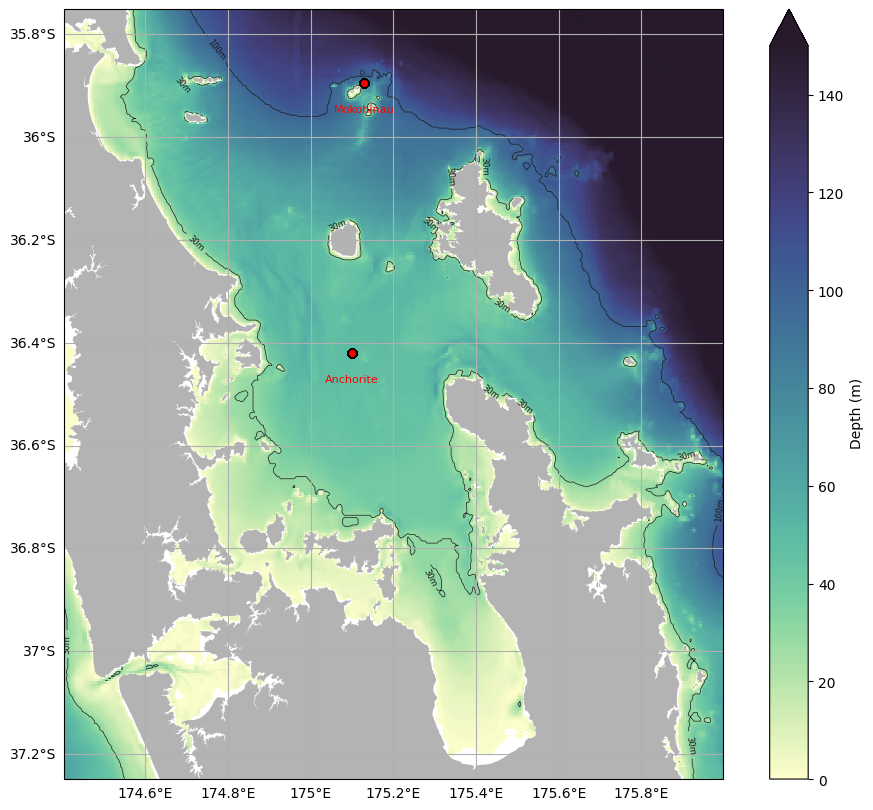

In [25]:
x0, x1 = gebco.lon.values[[0, -1]]
y0, y1 = gebco.lat.values[[0, -1]]

projection = transform = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection=projection))

# Depth map
depth = gebco.elevation.where(gebco.elevation < 0) * -1
depth.plot(ax=ax, cmap=cmocean.cm.deep, vmin=0, vmax=150, cbar_kwargs=dict(label="Depth (m)"), transform=transform)
c = depth.plot.contour(ax=ax, levels=[30, 100, 300], colors="0.1", linewidths=0.5, transform=transform)
c.clabel(fmt="%0.0fm", fontsize=6)

# Buoy locations
ax.plot(ancho.lon, ancho.lat, "o", markerfacecolor="red", markeredgecolor="black", transform=transform)
ax.plot(moko.lon, moko.lat, "o", markerfacecolor="red", markeredgecolor="black", transform=transform)
ax.text(ancho.lon.mean(), ancho.lat.mean()-0.05, "Anchorite", fontsize=8, color="red", ha="center", va="center", transform=transform)
ax.text(moko.lon.mean(), moko.lat.mean()-0.05, "Mokohinau", fontsize=8, color="red", ha="center", va="center", transform=transform)

# Land mask
land.plot(ax=ax, facecolor="0.7", transform=transform)

# Axis settings
ax.set_extent([x0, x1, y0, y1], crs=transform)
gl = ax.gridlines(draw_labels=["left", "bottom"])

#### Timeseries Old Anchorite Rock

Compare observations against the coarse and fine resolution hindcast datasets

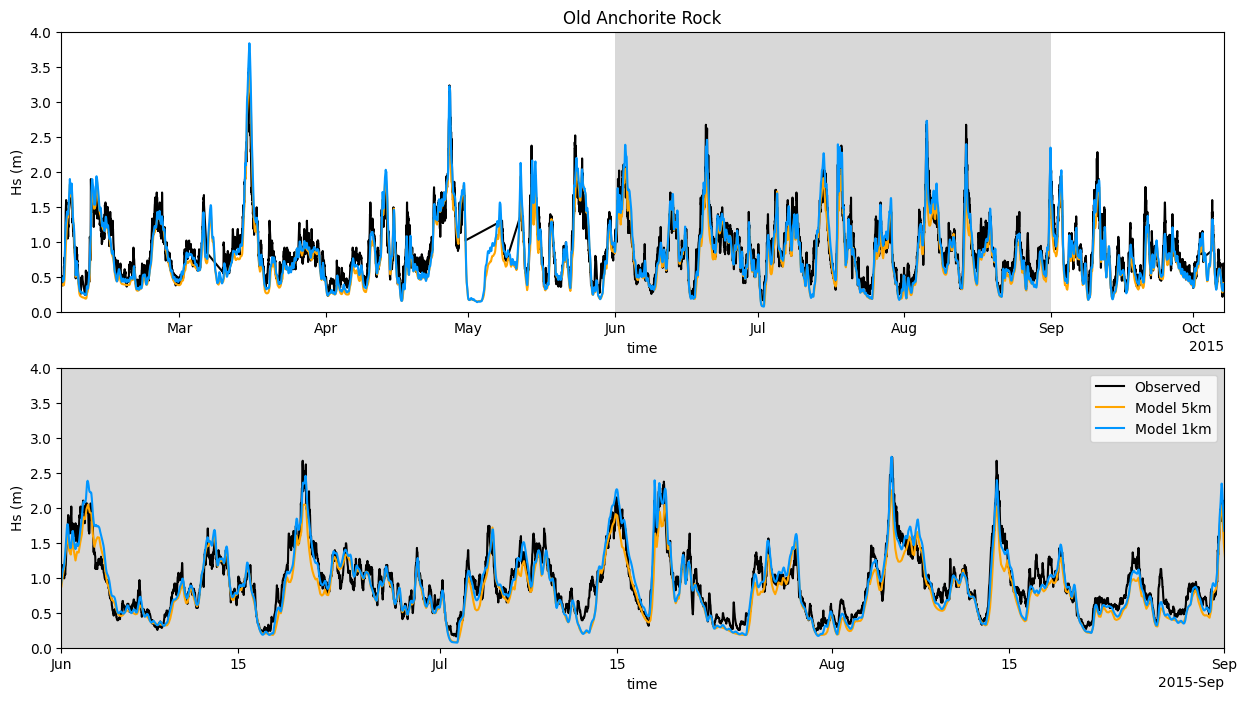

In [28]:
xlim = [datetime(2015, 6, 1), datetime(2015, 9, 1)]
ylim = [0, 4.0]

fig, axs = plt.subplots(2, 1, figsize=(15, 8))

obs = ancho
mod5km = hds_nz5km_ancho
mod1km = hds_nz1km_ancho

# Full period
ax = axs[0]
obs.hs.plot(ax=ax, label="Observed", color="k")
mod5km.hs.plot(ax=ax, label="Model 5km", color="orange")
mod1km.hs.plot(ax=ax, label="Model 1km", color="#0096FF")
ax.fill_between(xlim, [ylim[1], ylim[1]], alpha=0.5, facecolor="0.7")
ax.set_xlim(obs.time[[0, -1]])
ax.set_ylim(ylim)
ax.set_ylabel("Hs (m)")
ax.set_title("Old Anchorite Rock")

# Shaded period
ax = axs[1]
obs.hs.plot(ax=ax, label="Observed", color="k")
mod5km.hs.plot(ax=ax, label="Model 5km", color="orange")
mod1km.hs.plot(ax=ax, label="Model 1km", color="#0096FF")
ax.fill_between(xlim, [ylim[1], ylim[1]], alpha=0.5, facecolor="0.7")
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylabel("Hs (m)")
ax.set_title("")

l = ax.legend()

#### Timeseries Mokohinau

Compare observations against the coarse and fine resolution hindcast datasets

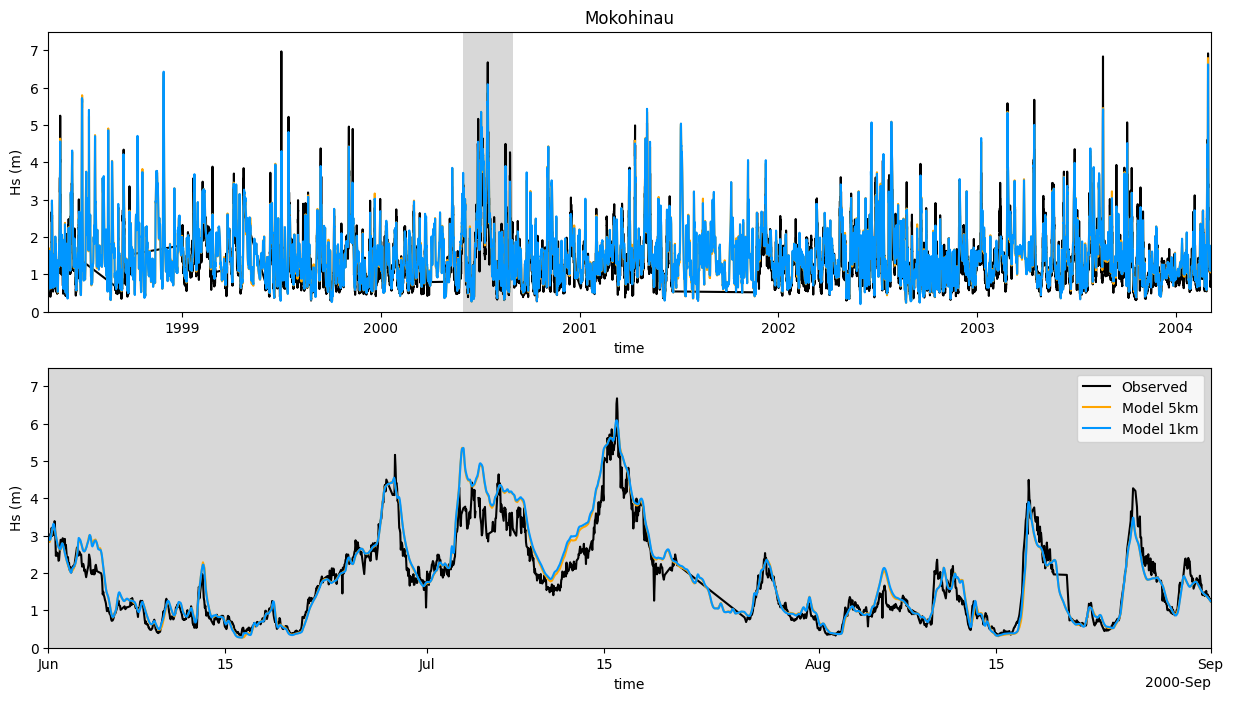

In [29]:
xlim = [datetime(2000, 6, 1), datetime(2000, 9, 1)]
ylim = [0, 7.5]

fig, axs = plt.subplots(2, 1, figsize=(15, 8))

obs = moko
mod5km = hds_nz5km_moko
mod1km = hds_nz1km_moko

# Full period
ax = axs[0]
obs.hs.plot(ax=ax, label="Observed", color="k")
mod5km.hs.plot(ax=ax, label="Model 5km", color="orange")
mod1km.hs.plot(ax=ax, label="Model 1km", color="#0096FF")
ax.fill_between(xlim, [ylim[1], ylim[1]], alpha=0.5, facecolor="0.7")
ax.set_xlim(obs.time[[0, -1]])
ax.set_ylim(ylim)
ax.set_ylabel("Hs (m)")
ax.set_title("Mokohinau")

# Shaded period
ax = axs[1]
obs.hs.plot(ax=ax, label="Observed", color="k")
mod5km.hs.plot(ax=ax, label="Model 5km", color="orange")
mod1km.hs.plot(ax=ax, label="Model 1km", color="#0096FF")
ax.fill_between(xlim, [ylim[1], ylim[1]], alpha=0.5, facecolor="0.7")
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylabel("Hs (m)")
ax.set_title("")

l = ax.legend()

## Validate hindcast

Make quantitative comparison between hindcast and observations

#### Stats functions

In [30]:
def make_colocs(obs, mod, var="hs", freq="3h"):
    """Join observations and model datasets into a colocated dataframe.

    Parameters
    ----------
    obs: xr.Dataset
        Observations dataset.
    mod: xr.Dataset
        Model dataset.
    freq: str
        Time frequency to resample model and data before joining.

    Returns
    -------
    df: pd.DataFrame
        Colocations dataframe with x and y columns representing obs and model.

    """
    ocol = obs.to_pandas().resample(freq).mean()[var]
    mcol = mod.to_pandas().resample(freq).mean()[var]
    df = pd.concat([ocol, mcol], axis=1).dropna()
    df.columns = ["x", "y"]
    return df


def n(df):
    """Number of colocations."""
    return df.dropna().shape[0]


def mad(df):
    """Mean absolute difference MAD."""
    return (df.y - df.x).abs().mean()


def rmsd(df):
    """Root-mean-square difference RMSD."""
    return np.sqrt(((df.y - df.x)**2).mean())


def bias(df):
    """Bias."""
    return (df.y - df.x).mean()

def si(df):
    """Scatter Index."""
    return np.sqrt((((df.y - df.x) - bias(df))**2).mean() ) / df.x.mean()

#### Plotting function

In [31]:
def scatter_validation(df, ax):
    dfq = df.quantile(q=np.arange(0, 1.01, 0.01))
    xlim = ylim = [0, df.max().max() * 1.1]
    text = f"Bias: {bias(df):0.2f} m\nMAD: {mad(df):0.2f} m\nRMSD: {rmsd(df):0.2f} m\nSI: {si(df):0.2f}\nN: {n(df):0.0f}"
    
    ax.plot(df.x, df.y, ".", markersize=4)
    ax.plot(dfq.x, dfq.y, "o")
    ax.plot(xlim, ylim, "k--")
    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("Hs Observations (m)")
    ax.set_ylabel("Hs Hindcast (m)")
    ax.annotate(text, xy=(0.03, 0.84), xycoords="axes fraction", fontsize=9, color="0.2")

    return ax

#### Old Anchorite Rock

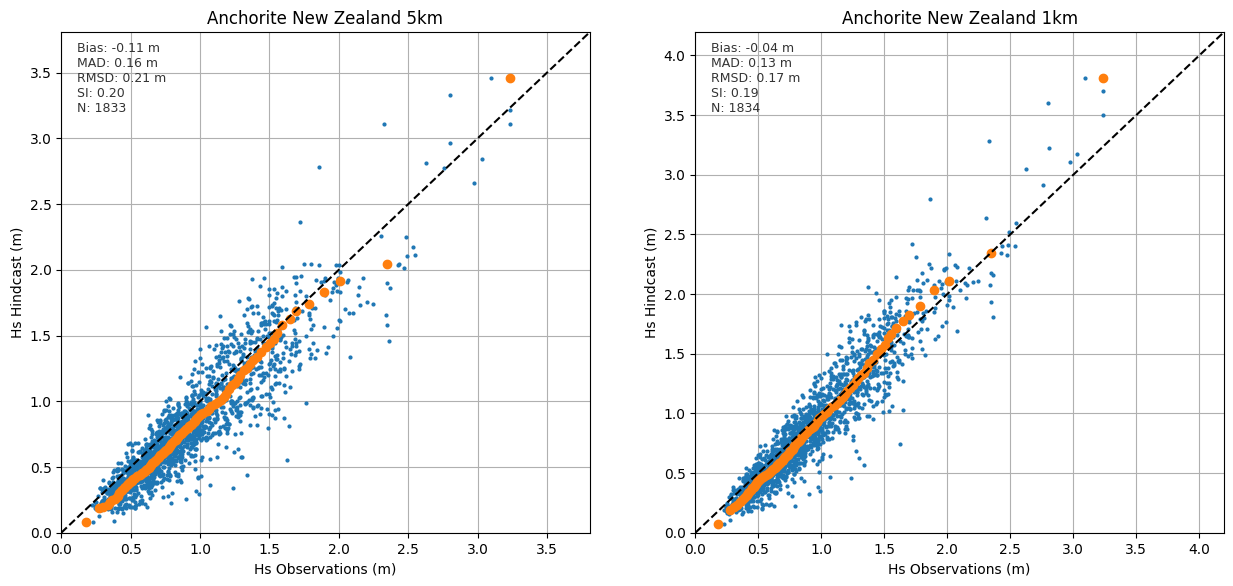

In [34]:
df_5km = make_colocs(ancho, hds_nz5km_ancho)
df_1km = make_colocs(ancho, hds_nz1km_ancho)

fig, axs = plt.subplots(1, 2, figsize=(15, 6.5))

# New Zealand 5km hindcast
ax = axs[0]
ax = scatter_validation(df_5km, ax)
ax.set_title("Anchorite New Zealand 5km")

# New Zealand 1km hindcast
ax = axs[1]
ax = scatter_validation(df_1km, ax)
t = ax.set_title("Anchorite New Zealand 1km")

#### Mokohinau

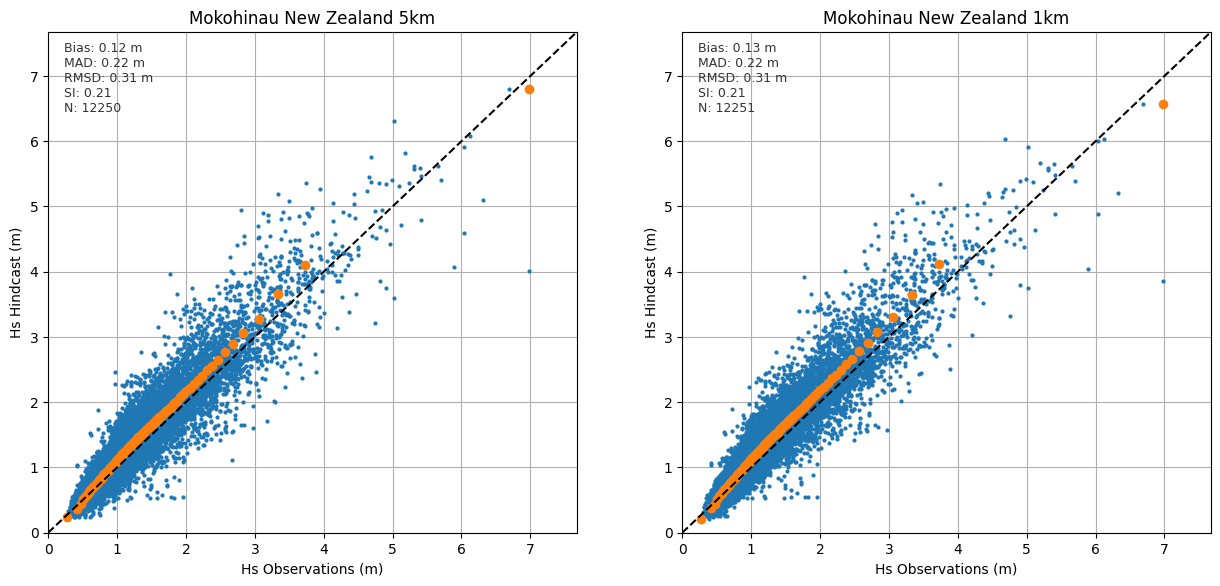

In [35]:
df_5km = make_colocs(moko, hds_nz5km_moko)
df_1km = make_colocs(moko, hds_nz1km_moko)

fig, axs = plt.subplots(1, 2, figsize=(15, 6.5))

# New Zealand 5km hindcast
ax = axs[0]
ax = scatter_validation(df_5km, ax)
ax.set_title("Mokohinau New Zealand 5km")

# New Zealand 1km hindcast
ax = axs[1]
ax = scatter_validation(df_1km, ax)
t = ax.set_title("Mokohinau New Zealand 1km")